### Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
X_data = pd.read_csv('dataset/fitur.csv')
X = X_data.values
X

array([[0.23784722, 0.77767612, 0.8912037 , 0.20540236],
       [0.42664931, 0.57548033, 0.90740741, 0.39538548],
       [0.16883681, 0.60933211, 0.98842593, 0.32087788],
       ...,
       [0.17361111, 0.        , 0.        , 0.        ],
       [0.10807292, 0.        , 0.        , 0.        ],
       [0.60069444, 0.94144556, 0.74305556, 0.90512099]])

In [3]:
y_data = pd.read_csv('dataset/target.csv')
y = y_data.values
y

array([[0.47114948],
       [0.56565198],
       [0.48841436],
       ...,
       [0.        ],
       [0.        ],
       [0.86324398]])

### Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
X_test = pd.DataFrame(X_test, columns=X_data.columns)
y_test = pd.DataFrame(y_test, columns=y_data.columns)
X_test.to_csv('dataset/X_test.csv', index=False)
y_test.to_csv('dataset/y_test.csv', index=False)

### Modeling

##### Inisialisasi bobot dan bias

In [6]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(4)])
        else:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(hidden_neuron[i-1])])
        bias.append([random.uniform(0, 1) for _ in range(hidden_neuron[i])])
    bobot_output = [random.uniform(0, 1) for _ in range(hidden_neuron[-1])]
    bias_output = random.uniform(0, 1)
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [7]:
def aktivasiX(activ, x): 
    # aktivasi relu
    if activ == 'relu':
        if x >= 0:
            return x
        else:
            return 0
    # aktivasi sigmoid
    elif activ == 'sigmoid':
        return 1 / (1 + math.exp(-x))
    # aktivasi softmax
    elif activ == 'softmax':
        return 1
    # aktivasi tanh
    else:
        return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

def turunanaktivasiX(activ, x): 
    # turunan aktivasi relu
    if activ == 'relu':
        if x > 0:
            return 1
        else:
            return 0
    # turunan aktivasi sigmoid
    elif activ == 'sigmoid':
        sig = 1 / (1 + math.exp(-x))
        return sig * (1 - sig)
    # turunan aktivasi softmax
    elif activ == 'softmax':
        return 0
    # turunan aktivasi tanh
    else:
        tan = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        return 1 - (tan) ** 2

##### Fungsi Training

In [8]:
def ann(epochs, hidden_layer, hidden_neuron, activation, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    konstan = 0
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(aktivasiX(activation, sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = aktivasiX(activation, sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunanaktivasiX(activation, prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
        elif mse == best_mse:
            konstan +=1
            if konstan == 3:
                print("MSE stabil, PELATIHAN DIHENTIKAN")
                break
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [9]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1, 2]
    neuron_values = [2, 3, 4]
    aktivasi_values = ['relu', 'sigmoid', 'tanh']
    lr_values = [0.0001, 0.001]
    epoch_values = [100, 200]

    hidden_layer_list = []
    hidden_neuron_list = []
    aktivasi_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []
    i = 0
    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for aktivasi in aktivasi_values:
                for lr in lr_values:
                    for epoch in epoch_values:
                        i += 1
                        print(f"KOMBINASI KE-{i}\nHIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, AKTIVASI={aktivasi}, LR={lr}, EPOCH={epoch}")
                        mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, tuple(hidden_neuron_combination), aktivasi, lr, X_train, y_train)
                        hidden_layer_list.append(hidden_layer)
                        hidden_neuron_list.append(tuple(hidden_neuron_combination))
                        aktivasi_list.append(aktivasi)
                        lr_list.append(lr)
                        epoch_list.append(epoch)
                        mse_list.append(mse)
                        bobot_list.append(bobot)
                        bias_list.append(bias)
                        bobot_output_list.append(bobot_output)
                        bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'aktivasi': aktivasi_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [10]:
tuning = tuning_hyperparameters(X_train, y_train)

KOMBINASI KE-1
HIDDEN LAYER=1, HIDDEN NEURON=(2,), AKTIVASI=relu, LR=0.0001, EPOCH=100
Epoch 1, MSE: 5.682182190881282
Epoch 2, MSE: 1.499097217391081
Epoch 3, MSE: 0.6488256288534063
Epoch 4, MSE: 0.4814645906135071
Epoch 5, MSE: 0.38188492442662453
Epoch 6, MSE: 0.3410201407810761
Epoch 7, MSE: 0.33589749889295806
Epoch 8, MSE: 0.3358676621118991
Epoch 9, MSE: 0.3358378302389816
Epoch 10, MSE: 0.335808003273328
Epoch 11, MSE: 0.3357781812140668
Epoch 12, MSE: 0.3357483640603203
Epoch 13, MSE: 0.33571855181121335
Epoch 14, MSE: 0.3356887444658729
Epoch 15, MSE: 0.3356589420234223
Epoch 16, MSE: 0.3356291444829848
Epoch 17, MSE: 0.3355993518436913
Epoch 18, MSE: 0.335569564104663
Epoch 19, MSE: 0.3355397812650292
Epoch 20, MSE: 0.33551000332391173
Epoch 21, MSE: 0.3354802302804406
Epoch 22, MSE: 0.3354504621337377
Epoch 23, MSE: 0.33542069888293424
Epoch 24, MSE: 0.3353909405271529
Epoch 25, MSE: 0.3353611870655235
Epoch 26, MSE: 0.3353314384971716
Epoch 27, MSE: 0.3353016948212235
Epo

##### Visualisasi hasil tuning

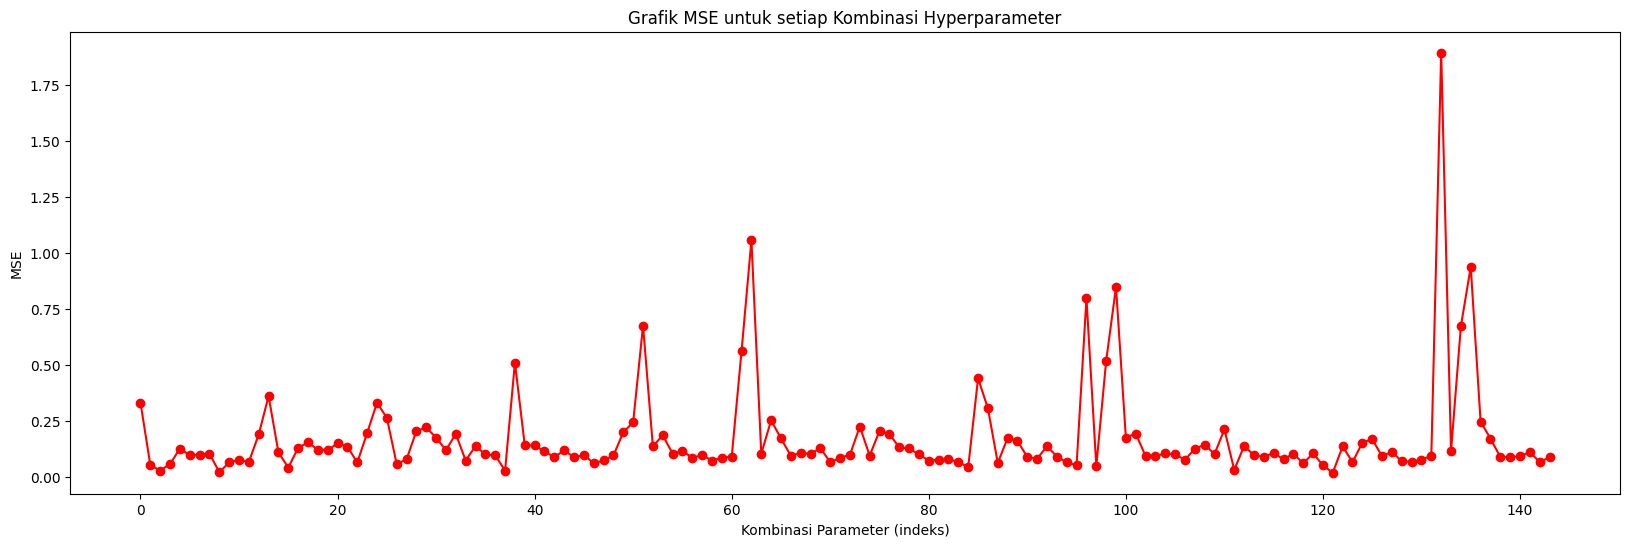

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [12]:
tuning.to_csv('hasiltuning/hasiltuning.csv', index=False)

In [13]:
tuning

,hidden_layer,hidden_neuron,aktivasi,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,1,"(2,)",relu,0.0001,100,0.333144,"[[[-0.2615389388779243, 0.050472874871591474],...","[[0.4819073277018717, -0.4078395782000591]]","[0.7218100617465232, 0.4112943831078636]",0.912953
1,1,"(2,)",relu,0.0001,200,0.053949,"[[[-0.2501732285609381, 0.5676680158347341], [...","[[0.17813843884859526, 0.047974146641973074]]","[0.8038067437414513, 0.547864494895299]",0.338951
2,1,"(2,)",relu,0.0010,100,0.030114,"[[[0.03933148416250525, 0.8667750478439633], [...","[[0.35871136865645037, 0.05501745726478298]]","[0.1476301574847731, 0.22922452802576024]",0.233571
3,1,"(2,)",relu,0.0010,200,0.059167,"[[[1.5635061201660234, -0.2796575549230775], [...","[[0.9714153457557431, -0.7637374833512283]]","[0.042486258933588976, 0.3770777715007137]",0.447467
4,1,"(2,)",sigmoid,0.0001,100,0.127806,"[[[0.7481538771091769, 0.6267047185293748], [0...","[[0.704032234424797, 0.8475609194718629]]","[0.8123215377559434, 0.1550729135752251]",0.186359
...,...,...,...,...,...,...,...,...,...,...
139,2,"(4, 4)",sigmoid,0.0010,200,0.089529,"[[[0.9647168473564773, 0.9869462302170974, 0.7...","[[0.6810490870334727, 0.1348509425212997, 0.99...","[0.8510624303887415, 0.2708641978706949, 0.329...",0.367540
140,2,"(4, 4)",tanh,0.0001,100,0.093677,"[[[0.5937046811571053, 0.21489525958701752, 0....","[[0.09453540744865374, 0.5176956229730367, 0.8...","[0.5004284823157761, 0.05334664755502713, 0.44...",0.860817
141,2,"(4, 4)",tanh,0.0001,200,0.111821,"[[[0.3521004902648738, 0.6236997829180004, 0.3...","[[0.7317163383270959, 0.6289608980908094, 0.17...","[0.501054321510095, 0.31073855656221067, 0.879...",0.902410
142,2,"(4, 4)",tanh,0.0010,100,0.068502,"[[[0.46661541025906084, 0.2747521368767725, 0....","[[0.5835365598325378, 0.8146677559114011, 0.81...","[0.35293314379888385, 0.9234778676240216, 0.80...",0.436167


In [14]:
best_index = tuning['mse'].idxmin()
best_hidden_layer_global = tuning['hidden_layer'][best_index]
best_hidden_neuron_global = tuning['hidden_neuron'][best_index]
best_lr_global = tuning['lr'][best_index]
best_epoch_global = tuning['epoch'][best_index]
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best Index:", best_index)
print("Best Hidden Layer:", best_hidden_layer_global)
print("Best Hidden Neuron:", best_hidden_neuron_global)
print("Best Learning Rate:", best_lr_global)
print("Best Epoch:", best_epoch_global)
print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best Index: 121
Best Hidden Layer: 2
Best Hidden Neuron: (4, 3)
Best Learning Rate: 0.0001
Best Epoch: 200
Best MSE: 0.020292740596255278
Best Bobot: [[[np.float64(0.6947982210354825), np.float64(0.5674789300596899), np.float64(0.6670230161646279), np.float64(0.693549573307115)], [np.float64(0.5492374963728203), np.float64(0.44936958257184456), np.float64(0.8609743208453873), np.float64(0.25088842907928266)], [np.float64(0.48734010612780326), np.float64(0.04579957582345762), np.float64(0.7803288535585265), np.float64(0.07621100620257724)], [np.float64(0.5244116346551543), np.float64(0.9520032886495706), np.float64(0.2811804496244311), np.float64(0.2565377994467847)]], [[np.float64(0.5863086372349364), np.float64(-0.9174874636092839), np.float64(0.737930107410976)], [np.float64(0.763637216636695), np.float64(-1.349789862088427), np.float64(0.6174289568872192)], [np.float64(0.5443636893338604), np.float64(-0.6932188671850967), np.float64(1.0154775872980624)], [np.float64(0.35417292328658